## Kütüphaneler

In [140]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector,ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# 🏆 Kaggle Batch Yarışması

**İlk Kaggle yarışmanıza hoş geldiniz!**

<img src='https://d32aokrjazspmn.cloudfront.net/materials/kaggle-batch-challenge.png' width=600>

Amacınız açık yarışma [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) için **çevrimiçi bir cevap göndermek**tir 🏠

Neyse ki, bootcamp'te daha önce konut veri seti ile karşılaştınız! **Baseline model** oluşturmanız için yarı rehberli olacaksınız ve sadece baseline oluşturduktan sonra onu geliştirmekte ve iyileştirmekte özgür olacaksınız. Problemi **pipeline'lar** kullanarak ele alacağız (en iyi pratik)!

Kaggle hakkında birkaç söz:
- Kaggle gönderilerinizi tüm katılımcılar arasında sıralar!
- Herkes 2 ay sonra genel sıralama tablosundan kaldırılır
- Günde 10'a kadar gönderi yapabilirsiniz

🧹 Bugün uzun notebook'unuzu **düzenli** tutmayı pratik yapmanın mükemmel günü 🧹
- Komut paletinden tüm başlıkları daraltın (`Cmd + Shift + P`)
- "İdempotent" kalın (`Restart & Run All` asla çökmemeli)
- Değişkenleri dikkatli olarak adlandırın ve silin

## Kaggle Kurulumu

👉 Yarışmaya katılmak istiyorsanız Kaggle'da hesap oluşturun

👉 [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) yarışmasına katılın


## Veri Yükleme

Yarışma talimatlarında, Kaggle'dan mevcut notebook klasörünüze ihtiyacınız olan her şeyi indirmek için gerekli adımları zaten çalıştırmış olmalısınız:

- `train.csv` sizin `X` ve `y` içeren `(1460, 81)` eğitim setinizdir
- `test.csv` ilişkili hedef `y` olmadan `(1459, 80)` test setinizdir 😈
- `sample_submission.csv` cevabınızı göndermek için gereken formatı açıklar

ℹ️ Veri setinin ayrıntılı açıklamasını [burada](https://d32aokrjazspmn.cloudfront.net/materials/kaggle_houses_data_description.txt) bulacaksınız. Yarışma boyunca buna başvurun!

Amacınız test setinizdeki eksik `y_pred`'i tahmin etmek ve `test_score`'unuzu ve sıralamanızı keşfetmek için göndermektir

❓ Eğitim veri setini `data` adlı bir DataFrame'e yükleyin ve `X` ve `y`'nizi oluşturun. Şekillerini inceleyin.

**İpucu:** CSV dosyasını kontrol ederseniz, `Id` adlı bir sütun olduğunu fark edeceksiniz. CSV dosyasını DF'ye okurken, iki ID sütunu oluşmaması için `index_col="Id"` ayarladığınızdan emin olun 😉

In [170]:
url = "https://d32aokrjazspmn.cloudfront.net/materials/houses-train-raw.csv"
data = pd.read_csv(url)
data.head()

X = data.drop(["SalePrice","Id"],axis=1)
y = data["SalePrice"]




# 🐣 1. BASELINE

## 1.1 İlk Özellik Genel Bakış

79 özellik ilk baseline pipeline için tek tek ele alınamayacak kadar fazla! Onları yalnızca `dtype`'larına göre ele alalım:

❓ Kaç sayısal özellik ve kaç kategorik özelliğimiz var?

In [142]:
#num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(include="object").columns

#n = len(num_cols)
c = len(cat_cols)

print(c)



43


❓ Eğitim setimizdeki her kategorik özellik için **benzersiz değer** sayısını içeren `feat_categorical_nunique` adlı bir Series oluşturun. Toplamda kaç benzersiz kategori var?

In [143]:
feat_categorical_nunique = X[cat_cols].nunique()
feat_categorical_nunique.sum()

251

🤔 Tüm kategorik özellikleri `OneHotEncode` edersek, özellik matrisimiz `X_preproc` sadece 1400 gözlem için neredeyse 300 (yüksek oranda ilişkili) özellikle oldukça büyük ve seyrek hale gelir. İdeal olarak, modelimize maksimum ~50 özellik beslemeyi hedeflemeliyiz (📚 bu [pratik kuralı](https://datascience.stackexchange.com/a/11480/98300) okuyun)

Ön işleme sonrası kategorik özellik sayısını azaltmak için bildiğimiz 2 ana strateji var:
1. **[Kaldır](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** modelimize çok az açıklama getiren özellikler; bu özellik öneminin istatistiksel analizi gerektirebilir
2. **[Ordinal kodlama](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (one-hot kodlama yerine) kategorik özellikler tamsayılara; ancak bu, düzgün ele alınmazsa zararlı olabilecek bir "sıra" kavramı (1 > 2 > 3 > ...) oluşturur!

❓ Kategorik özellik başına benzersiz değer sayısının **histogramını** çizin. Hızlı kazançlar görüyor musunuz?

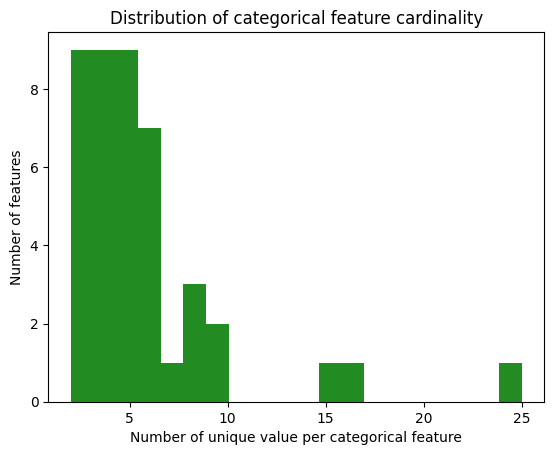

In [144]:
plt.figure()
plt.hist(feat_categorical_nunique, bins=20, color="forestgreen")
plt.xlabel("Number of unique value per categorical feature")
plt.ylabel("Number of features")
plt.title("Distribution of categorical feature cardinality")

plt.show()

💡 Başlangıç noktası olarak, **7 veya daha fazla benzersiz değeri** olan tüm özellikleri basitçe **kaldırmaya** ve geri kalanını one-hot kodlamaya ne dersiniz? Ordinal kodlama ve istatistiksel özellik seçimini pipeline'ımızın bir sonraki iterasyonu için saklayalım.

❓ OHE yapılacak özelliklerin adlarını aşağıda `feat_categorical_small` adlı listede saklayın. Kaç özellik OHE edilecek?

In [145]:
feat_categorical_small = feat_categorical_nunique[
    (feat_categorical_nunique > 1) &
    (feat_categorical_nunique < 7)
].index.tolist()

len(feat_categorical_small)


34

🧪 Kodunuzu aşağıda test edin (ve geçtikten sonra hücreyi temizleyin)

In [146]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S17D2-S-kaggle-competition/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master



## 1.2 Baseline Pipeline

### a) Ön İşleme

❓ Aşağıda açıklanan temel ön işleme pipeline'ını kodlayalım. `preproc_baseline` altında kaydedin.

Kategorik özellikler için:
- En sık değerlerle Simple-Impute
- Başlangıçta 7'den az benzersiz değeri olan özellikleri One-Hot Encode et
- Diğer tüm özellikleri kaldır


Sayısal özellikler için:
- `mean` stratejisiyle Simple-Impute
- Min-Max Scale


<details>
    <summary>ℹ️ Profesyonel ipucu için buraya tıklayın</summary>

Eğer kendinize güveniyorsanız, `Pipeline` veya `ColumnTransformer`'ın daha uzun söz dizimi yerine Sklearn'in daha kısa söz dizimi `make_pipeline` veya `make_column_transformer`'ını deneyebilirsiniz; her adıma manuel olarak isim vermekten kaçınmak istiyorsanız da yararlıdır.
</details>

In [152]:

X = data.drop(["SalePrice", "Id"], axis=1)
y = data["SalePrice"]


pseudo_cat_cols = ["MSSubClass", "MoSold"]


num_cols = X.select_dtypes(include="number").columns.difference(pseudo_cat_cols)


cat_cols = X.select_dtypes(include="object").columns.tolist() + pseudo_cat_cols


feat_categorical_nunique = X[cat_cols].nunique()


feat_categorical_small = feat_categorical_nunique[
    (feat_categorical_nunique >= 2) &
    (feat_categorical_nunique < 7)
].index.tolist()


feat_categorical_small = [
    col for col in feat_categorical_small
    if col != "Utilities"
]


cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

preproc_baseline = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, feat_categorical_small)
    ],
    remainder="drop"
)


❓ Ön işlenmiş DataFrame'inizin **şekline** bakın ve `shape_preproc_baseline`'a kaydedin

In [154]:
X_prepared = preproc_baseline.fit_transform(X)

shape_preproc_baseline = X_prepared.shape
print(shape_preproc_baseline)


#print(sorted(num_cols))
#print(sorted(feat_categorical_small))



(1460, 178)


🧪 Kodunuzu aşağıda test edin

In [155]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S17D2-S-kaggle-competition/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED         [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master



### b) Tahminleyici Ekle

❓ `preproc_baseline`'a basit bir Decision Tree modeli ekleyin ve `pipe_baseline` değişkeninde saklayın.

In [160]:
from sklearn.tree import DecisionTreeRegressor

pipe_baseline = Pipeline(steps=[
    ("preprocessing", preproc_baseline),
    ("model", DecisionTreeRegressor(random_state=42))
])

#pipe_baseline.fit(X, y)

#pipe_baseline

param_grid = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_leaf": [1, 5, 10]
}


### c) Çapraz Doğrulama

❓ Kaggle [yarışma değerlendirme kurallarını](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) okuyun. Hangi performans metriğine ihtiyacınız var? Sklearn'de hazır olarak mevcut mu?

Ne yazık ki değil! Herhangi bir çapraz doğrulama veya Grid Search'e geçmek için özel `sklearn.metrics.scorer` nesnemizi oluşturmamız gerekecek. İşlem aşağıda açıklanmıştır:


1. [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) kullanarak `scoring` `kwarg` için değer olarak geçirilebilen `rmsle` adlı bir scorer oluşturun:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2. _Maksimize edildiğinde_ en iyi olan negatif karşılığını `rmsle_neg` oluşturun; `GridSearchCV` her zaman bir skoru _maksimize_ etmeye çalıştığı için bu daha sonra işe yarayacak 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formülü

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [162]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def rmsle(y_true, y_pred):
    return np.sqrt(
        np.mean(
            (np.log1p(y_pred) - np.log1p(y_true)) ** 2
        )
    )
rmsle_scorer = make_scorer(
    rmsle,
    greater_is_better=False
)
rmsle = rmsle_scorer

scores = cross_val_score(
    pipe_baseline,
    X,
    y,
    cv=5,
    scoring=rmsle
)

scores

rmsle_neg = make_scorer(
    rmsle,
    greater_is_better=False
)

gs = GridSearchCV(
    pipe_baseline,
    param_grid=param_grid,
    cv=5,
    scoring=rmsle_neg
)

❓ Baseline performansınıza ilk bakış için bu metriği kullanarak `pipe_baseline`'ınızı 5-kat çapraz doğrulama yapın.    

Ortalama skorunuzu `score_baseline` olarak saklayın

In [163]:
scores = cross_val_score(
    pipe_baseline,
    X,
    y,
    cv=5,
    scoring=rmsle
)


score_baseline = scores.mean()
print(score_baseline)

-0.20904466694262788


### d) Baseline Tahmini

❓ `data` klasöründe sakladığınız Kaggle `test.csv` veri setinden `y_pred_baseline`'ı tahmin edin.

In [164]:
X_test = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X, y)
y_pred_baseline = pipe_baseline.predict(X_test)


❓ Son olarak, göndermeye hazır CSV'nizi `data` klasöründe `submission_baseline.csv` olarak saklayın. Kaggle'ın gereken formatını **dikkatli bir şekilde okuyun** ve anlayın ve aşağıda test edin (şimdilik bu baseline'ı Kaggle'a göndermenize gerek yok).

In [165]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0


In [166]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)

🧪 Kodunuzu test edin

In [167]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S17D2-S-kaggle-competition/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 4 items

test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.47s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push origin master



# 🏋️‍♀️ 2. İTERASYONLAR 

🎉 🎉 Tam pipeline'lı bir baseline model oluşturduğunuz için tebrikler! Şimdi iterasyon yapmanın ve performansı iyileştirmenin ne kadar kolay olduğunu göreceksiniz 🚀

Şimdi amacınız tahmininizi iyileştirmek ve **Recap'ten en az 30 dakika önce** Kaggle'a göndermektir ⏳

Aşağıda iyileştirmeler için bazı önerilerimiz var: **savaşlarınızı seçin** ve pipeline'ınızı uygun gördüğünüz şekilde **aşamalı olarak** iyileştirin!

**Tahminleyiciler**

- Ağaç tabanlı ensemble'lar (bugün mutlaka denenmeli); muhtemelen çok kategorik özelliği olan problemler için en uygun
- Stacking!
- XGBoost!

**Ön İşleme** (ilk ensemble modeliniz çalıştıktan sonra)

- Değerlerinde gizli sıra kavramı olan kategorik özelliklerin **Ordinal Kodlaması** (örn. "kötü", "ortalama", "iyi")
- Gereksiz özellikleri kaldırmak için **İstatistiksel Özellik Seçimi** (aşırı öğrenmeyi önler ve eğitim süresini kısaltır)
- `SalePrice` yerine `log(SalePrice)` tahmin et?
- 🤷

## 2.1 Ön İşleme İterasyonu ♲ 
**⚠️ Bölüm 2.2'de tahminleyicilerinizde iterasyon yaptıktan sonra buraya geri dönün ⚠️**

⏩ Kullanımda değilsem beni daralt!

### a) Ordinal Kodlama (~1s)

❓ Aşağıdaki özelliğe bakın. Akıllıca bir şekilde sayısal olarak kodlanamaz mı?
```
ExterQual: Dıştaki malzemenin kalitesini değerlendirir
		
       Ex	Mükemmel
       Gd	İyi
       TA	Ortalama/Tipik
       Fa	Adil
       Po	Zayıf
```

💡 Neyse ki, `OrdinalEncoder` ve `categories` argümanı tam da bunu yapmamıza izin veriyor! Aşağıda kontrol edin ve bunun nasıl çalıştığını anladığınızdan emin olun 👇

In [168]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Sıra sizde**: kategorik ön işleyicinizi şunlara bölün

- **Bazı özellikleri** (seçiminize göre) ordinal kodlamak için `preproc_ordinal`
- Diğerlerini one-hot kodlamak için `preproc_nominal`


<details>
    <summary>İpuçları</summary>

- Özelliklerin adlarını ve sıralı değerlerini sabit kodlamaktan kaçınamayacaksınız! Düzenli olun!
- Kötü sürprizlerden kaçınmak için özelliklerinizi alfabetik olarak sıralamanız iyi bir uygulamadır
</details>

In [178]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer


ordinal_features = [
    "ExterQual", "ExterCond",
    "BsmtQual", "BsmtCond", "BsmtExposure",
    "BsmtFinType1", "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual", "GarageCond",
    "PoolQC"
]

ordinal_features = sorted(ordinal_features)

ordinal_categories = [
    ["Po", "Fa", "TA", "Gd", "Ex"],      
    ["Po", "Fa", "TA", "Gd", "Ex"],        
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"],  
    ["NA", "No", "Mn", "Av", "Gd"],        
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], 
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],  
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"],  
    ["Po", "Fa", "TA", "Gd", "Ex"],       
    ["Po", "Fa", "TA", "Gd", "Ex"],       
    ["Po", "Fa", "TA", "Gd", "Ex"],       
    ["Po", "Fa", "TA", "Gd", "Ex"],        
    ["Po", "Fa", "TA", "Gd", "Ex"],        
    ["NA", "Fa", "TA", "Gd", "Ex"],       
]
preproc_ordinal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=ordinal_categories,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])


cat_cols = X.select_dtypes(include="object").columns

nominal_features = sorted(
    [col for col in cat_cols if col not in ordinal_features]
)
preproc_nominal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preproc_full = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("ord", preproc_ordinal, ordinal_features),
        ("nom", preproc_nominal, nominal_features)
    ],
    remainder="drop"
)

### b) İstatistiksel Özellik Seçimi (~30dk)

Amacımız aşırı öğrenmeyi sınırlamak ve eğitim süresini kısaltmak için en az ilginç özellikleri kaldırmaktır.  

🔥 Pipeline'ınızda doğrudan Sklearn'in [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) dönüştürücülerini kullanacağız!

❗️ Başlamak için bugün **sadece Seçenek 1'i** denemenizi öneriyoruz. Seçenek 2 ve 3 Recap'te düzeltilecek!

#### Seçenek 1 (Önerilen) - <font color=green>Tek değişkenli</font> Özellik Seçimi
*hedef `y` ile karşılıklı bilgilerine dayalı*

- `preproc` pipeline'ınızın sonuna bir `SelectPercentile` filtresi eklemeyi tereddüt etmeyin.
- Bu, tek tek alındığında hedefimizi en az açıklayan özellikleri filtreleyecek!
- SelectPercentile'a geçirmenizi önerdiğimiz istatistiksel test `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Karşılıklı bilgi nedir? Buraya tıklayın!</summary>

- [Karşılıklı Bilgi](https://en.wikipedia.org/wiki/Mutual_information) iki olasılık dağılımı arasındaki **istatistiksel** mesafedir
- Korelasyon iki rastgele değişken arasındaki **doğrusal** mesafedir
- Karşılıklı Bilgi daha geneldir ve X'i gözlemledikten sonra Y'deki belirsizliğin azalmasını ölçer.
- Öte yandan, zaten düzgün değişkenlerle (sürekli sayısal değişkenler gibi) çalıştığınızı biliyorsanız, bazen korelasyon onlar hakkında daha fazla bilgi verebilir, örneğin ilişkileri monoton ise.

[Bu animasyona](https://twitter.com/ari_seff/status/1409296508634152964) bakın
</details>

In [179]:
feature_selector = SelectPercentile(
    score_func=mutual_info_regression,
    percentile=50
)
preproc_with_fs = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("feature_selection", feature_selector)
])
pipe_fs = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("feature_selection", feature_selector),
    ("model", DecisionTreeRegressor(random_state=42))
])

scores_fs = cross_val_score(
    pipe_fs,
    X,
    y,
    cv=5,
    scoring=rmsle
)

scores_fs.mean()

-0.20134679286627324

#### Seçenek 2 - <font color=green>Çok değişkenli</font> Özellik Seçimi
*hedef `y` ile birleşik ilişkilerine dayalı*

🤔 Diğerleriyle birleştirildiğinde bile hedefimizi tahmin etmeye yardımcı olmayan özellikleri kaldırmak istiyoruz.

1️⃣ Bunu yapmak için, bir tahminleyici ile birlikte [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metriğini kullanabileceğimizi unutmayın! Her özellik için bir pipeline eğitir ve hangi özelliğin rastgele karıştırıldığında performans skorumuzu en çok *düşürdüğünü* tahmin eder. Bunlar kaldırmak istemediğimiz en önemli özelliklerimiz olacaktır.

En iyi şey, `scikit-learn`'in bu metodolojiyi [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) dönüştürücüsü sayesinde doğrudan `preproc` pipeline'ınıza entegre etmenize izin vermesidir; bu, `cross_val_score`'a göre en az önemli özellikleri özyinelemeli olarak kaldıracaktır.

Ancak çok özelliğiniz olduğunda, bu işlem eğitilmesi son derece uzun sürebilir.

2️⃣ Alternatif olarak, daha hızlı bir yol, fit edildiğinde zaten bazı `feature_importance` ölçüleri çıkaran modelleri kullanmak olacaktır. Örneğin, Gini tabanlı `feature_importance_` ile ağaçlar veya L1 `coef_` ile Lasso regresyonları. `scikit-learn` zaten tam da bunu yapmak için [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) dönüştürücüsüne sahiptir.

In [ ]:
# YOUR CODE HERE

#### Seçenek 3 - <font color=green>Denetimsiz</font> Seçim?
*sadece `X`'in özelliklerine dayalı filtre*

❓ Hızlı bir kazanç, en düşük varyansa sahip özellikleri kaldırmaktır. Düşünün: sadece bir değeri olan bir özellik yararsızdır (ve 0 varyansa sahiptir).

Pipeline'ınızın sonuna bir [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) eklemeyi tereddüt etmeyin!

In [ ]:
# YOUR CODE HERE

❓ Ek olarak, sadece **sayısal özelliklerimiz** arasındaki korelasyonu kontrol edebiliriz

- Herhangi bir **sayısal** özelliğin diğerleriyle neredeyse tamamen korelasyonlu olup olmadığını görsel olarak kontrol etmek için [Pearson korelasyonu](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) ile birlikte bir ısı haritası kullanın
- En yüksek çok doğrusal bağlantıya sahip özellikleri kontrol etmek için `statsmodels`'den `VIF` kullanın

In [ ]:
# YOUR CODE HERE

❓ **Ordinal özellikler** için, bazı **ordinal kodlanmış** özelliklerin diğerleriyle neredeyse tamamen benzer şekilde "sıralanıp" sıralanmadığını kontrol etmek için bunun yerine [Spearman rank korelasyonu](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) kullanabiliriz. Tekrar bir ısı haritası çizmekten çekinmeyin.

In [ ]:
# YOUR CODE HERE

❓ Şimdi, belirli bir (Spearman + Pearson) korelasyon eşiğinin ötesinde istediğiniz herhangi bir özelliği kaldıran pipeline'ınızda bir "filtre" oluşturmaktan çekinmeyin; özel bir dönüştürücü sınıfa ihtiyacınız olacak.

In [ ]:
# YOUR CODE HERE

### c) Döngüsel Özellikleri İşle

❓ Zaman tabanlı özelliklerimiz var, neden onları döngüsel özelliklere **dönüştürmüyoruz**?

🔎 Bunu neden ve nasıl yaptığımız hakkında daha fazla bilgi edinmek istiyorsanız, `Prepare the dataset` ünitesinin `Preprocessing Workflow` yarışmasına geri dönün.

### d) Hedef Mühendisliği (~15dk)

❓ RMS**L**E'yi minimize etmemiz isteniyor. Hedefimizin `log`'unu doğrudan tahmin etmek için neden dönüştürmüyoruz?
- `y` hedefinin histogramını kontrol edin
- Normal dağılımlı değişkenlerin doğrusal veya parametrik modellerle tahmin edilmesi daha kolay olmalıdır
- `y_log` ve yeni performans metriklerinizi oluşturun
- Sonunda tahminlerinizin üssünü almayı unutmayın!

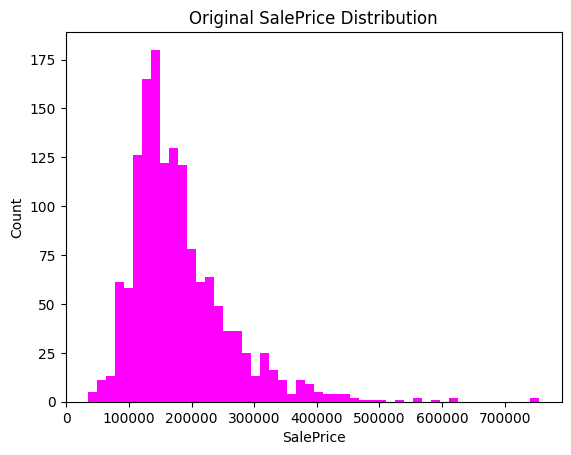

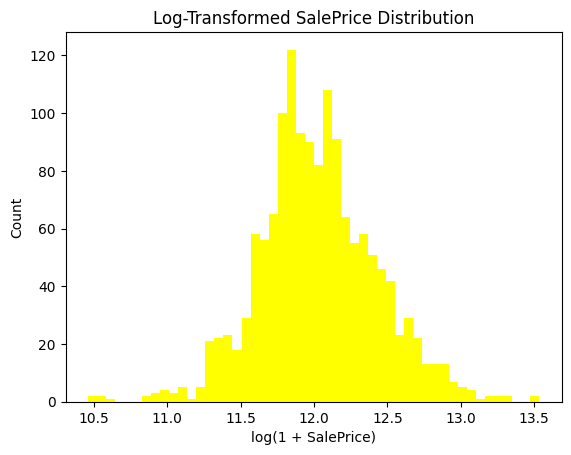

In [189]:
plt.figure()
plt.hist(y, bins=50,color="fuchsia")
plt.title("Original SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

y_log = np.log1p(y)

plt.figure()
plt.hist(y_log, bins=50,color = "yellow")
plt.title("Log-Transformed SalePrice Distribution")
plt.xlabel("log(1 + SalePrice)")
plt.ylabel("Count")
plt.show()


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_log_scorer = make_scorer(
    rmse,
    greater_is_better=False
)


scores_log = cross_val_score(
    pipe_baseline,
    X,
    y_log,
    cv=5,
    scoring=rmse_log_scorer
)

scores_log.mean()
y_pred_log = pipe_baseline.fit(X, y_log).predict(X_test)

y_pred = np.expm1(y_pred_log)


## 2.2 Model İterasyonu ♻

#### a) Ön İşleme Pipeline'ının Son Versiyonu
❓ Aşağıda ön işleme pipeline'ınızın yeni bir tanımıyla başlamanızı tavsiye ediyoruz. Yukarıdaki mevcut kodunuzdan kopyala-yapıştır yapın.

Bu şekilde gerektiğinde hızlıca güncelleyebilir ve ardından mümkün olan en iyi modeli bulmak için birçok model türü deneyebilirsiniz. GridSearch deneyebilirsiniz (bu çok zaman alabilir) veya model model gidebilirsiniz.

Önceki ünitelerde ve bugün öğrendiğiniz farklı modellerden bir veya daha fazlasını deneyebilirsiniz. 

👉 Hedefleriniz:

  - **En az bir doğrusal model deneyin**
  
  - **Bu ünitede keşfettiğiniz ağaç tabanlı modellerden en az birini deneyin**.

  - Farklı modellerinizin **çapraz doğrulama** skorlarını karşılaştırın.

  - Farklı modellerin çapraz doğrulanmasının **ne kadar sürdüğünü karşılaştırmak** da ilginçtir. 🔎 Bir notebook hücresinin yürütülmesini zamanlamak için hücrenin ilk satırına `%%time` sihirli komutunu ekleyin.

In [190]:
%%time

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])


preproc_ordinal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])


preproc_nominal = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


preproc_full = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("ord", preproc_ordinal, ordinal_features),
        ("nom", preproc_nominal, nominal_features)
    ],
    remainder="drop"
)


pipe_ridge = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("model", Ridge(alpha=1.0))
])

scores_ridge = cross_val_score(
    pipe_ridge,
    X,
    y_log,
    cv=5,
    scoring=rmse_log_scorer
)

scores_ridge.mean()




CPU times: user 4.44 s, sys: 6.66 s, total: 11.1 s
Wall time: 1.05 s


-0.1428927929880392

In [191]:
%%time
pipe_tree = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("model", DecisionTreeRegressor(
        max_depth=10,
        min_samples_leaf=10,
        random_state=42
    ))
])

scores_tree = cross_val_score(
    pipe_tree,
    X,
    y_log,
    cv=5,
    scoring=rmse_log_scorer
)

scores_tree.mean()


CPU times: user 531 ms, sys: 39.4 ms, total: 570 ms
Wall time: 569 ms


-0.18377740714575258

In [192]:
%%time
pipe_rf = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("model", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

scores_rf = cross_val_score(
    pipe_rf,
    X,
    y_log,
    cv=5,
    scoring=rmse_log_scorer
)

scores_rf.mean()


CPU times: user 52 s, sys: 1.31 s, total: 53.3 s
Wall time: 6.13 s


-0.14161990022621693

In [193]:
results = pd.DataFrame({
    "Model": ["Ridge", "DecisionTree", "RandomForest"],
    "CV_Log_RMSE": [
        -scores_ridge.mean(),
        -scores_tree.mean(),
        -scores_rf.mean()
    ]
})

results

,Model,CV_Log_RMSE
0,Ridge,0.142893
1,DecisionTree,0.183777
2,RandomForest,0.141620


# 🏅GÖNDERİM 

Kaggle'a göndererek gerçek test skorunuzu keşfetme zamanı! 

👉 Modelinizin ne kadar iyi olduğunu görmek için sonraki adımları takip edin ve tamamlayın!

In [194]:
X_test = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

2.1'deki isteğe bağlı döngüsel özellik işlemini çalıştırdıysanız, X_test'i pipeline'ınıza beslemeden önce ekstra sütunları eklemek için aşağıdaki hücreyi çalıştırmanız gerekecek.

In [ ]:
# If needed, add cyclical feature columns to X_test like we did to X
if 'months_in_a_year' in locals():
    # months_in_a_year is defined, so we need to add the cyclical features
    X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
    X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

    X_test.drop(columns=['MoSold'], inplace=True)

👉 En iyi tahminleyicinizi kullanarak tahmin yapın ve sonuçları `predictions`'da saklayın.

In [197]:
best_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipe_best = Pipeline(steps=[
    ("preprocessing", preproc_full),
    ("model", best_model)
])

pipe_best.fit(X, y_log)
y_pred_log_best = pipe_best.predict(X_test)
predictions = np.expm1(y_pred_log_best)
print(predictions)


[126244.93612425 150941.22759338 180551.40069539 ... 151292.35387288
 112836.24724059 232722.83353588]


👉 Tahminlerinizi Kaggle'a göndermek için hazırlamak üzere aşağıdaki hücreleri çalıştırın.

In [198]:
# Create a DataFrame in the correct format
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,126244.936124
1,1462,150941.227593
2,1463,180551.400695
3,1464,182929.493348
4,1465,196254.767314
...,...,...
1454,2915,83162.322105
1455,2916,83282.321019
1456,2917,151292.353873
1457,2918,112836.247241


In [199]:
# Export to Kaggle format submission
results.to_csv("submission_final.csv", header=True, index=False)

👉 Kaggle'a gidin ve tahminlerinizi gönderin. Test skorunuz nedir? Elde ettiğiniz doğrulama skorlarıyla karşılaştırın.
